<a href="https://colab.research.google.com/github/Chanura04/ML-Coursework/blob/main/20240955.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [21]:
!pip install keras-tuner 

In [22]:
import pandas as pd
# from google.colab import drive
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import keras_tuner as kt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras import layers, regularizers
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
import tensorflow as tf

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
import random
random.seed(SEED)
tf.random.set_seed(SEED)

## Load the dataset

In [23]:
url_x = "https://raw.githubusercontent.com/Chanura04/ML-Coursework/main/dataset/processed/X.csv"
url_y = "https://raw.githubusercontent.com/Chanura04/ML-Coursework/main/dataset/processed/y_data.csv"

## Check dataset behaviour

In [24]:
X=pd.read_csv(url_x)
y=pd.read_csv(url_y)
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0,0,34,1,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,0,0,0,2,1,0,1,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,0,0,45,0,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,0,2,1,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [80]:
X["TotalCharges"]

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [25]:
y.head()

,Churn
0,0
1,0
2,1
3,0
4,1


In [26]:
X.shape

(7043, 26)

In [27]:
y.shape

(7043, 1)

### Split Data into Training, Validation, and Test Sets

In [28]:
# X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_temp, y_train, y_temp= train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test= train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4930, 26)
Shape of y_train: (4930, 1)
Shape of X_val: (1056, 26)
Shape of y_val: (1056, 1)
Shape of X_test: (1057, 26)
Shape of y_test: (1057, 1)


In [29]:
np.sum(y_val==1)

c:\Users\chanu\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Churn    280
dtype: int64

In [30]:
np.sum(y_val==0)

Churn    776
dtype: int64

In [31]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [32]:
# 2. Initialize the scaler
scaler = StandardScaler()

# 3. FIT AND TRANSFORM the training data (Learns the mean/std and applies the scaling)
X_train = scaler.fit_transform(X_train)

# 4. ONLY TRANSFORM the test data (Applies the mean/std learned from the training data)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [33]:
X_train[0]

array([-0.86491011, -0.39085667, -0.76833605, -0.51960175, -0.94205683,
        0.34812163, -0.79284117, -0.50930152, -0.61564723, -0.6209798 ,
       -0.52495398,  1.3229474 , -0.74823939, -1.23061152,  0.41813912,
       -0.75926071, -0.67727687,  0.95699003, -0.44701491,  0.73085155,
       -0.46294185, -0.45961109, -0.50371663, -0.49438736,  1.24739147,
       -0.53098644])

Text(0.5, 1.0, 'Count Plot for Churn')

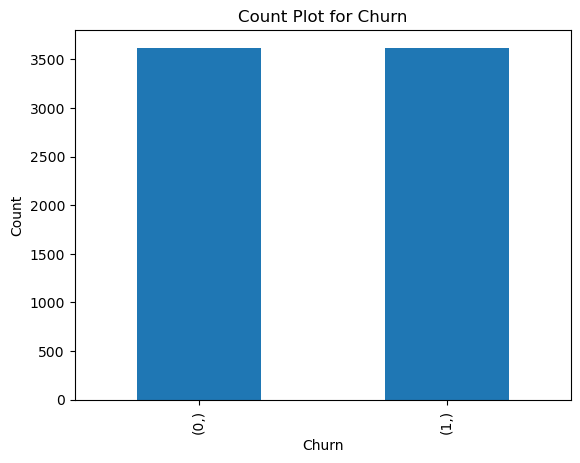

In [34]:
count=y_train.value_counts()
count.plot(kind='bar')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Count Plot for Churn')

Text(0.5, 1.0, 'Count Plot for Churn')

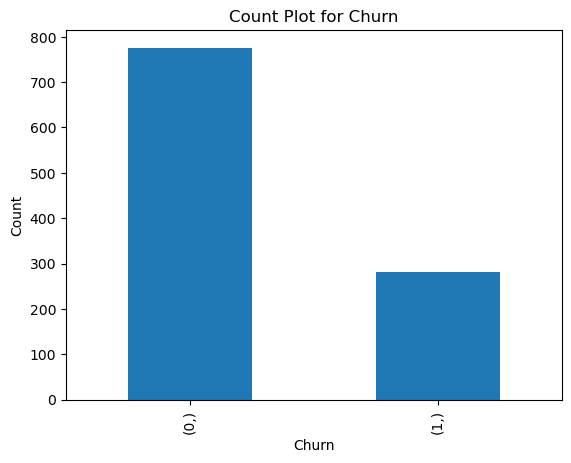

In [35]:
count=y_test.value_counts()
count.plot(kind='bar')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Count Plot for Churn')

In [36]:
def plot_history(history):
    # Loss
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Binary Crossentropy")
    plt.legend()


    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()


    # AUC
    plt.subplot(1,3,3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title("AUC Curve")
    plt.xlabel("Epochs")
    plt.ylabel("AUC Score")
    plt.legend()
    plt.show()





## Train Neural Network

#### Experiment 01

In [37]:
input_dim=X_train.shape[1]
input_dim

26

In [38]:
def make_baseline_model(input_dim,
                        units1=64,
                        units2=32,
                        dropout=0.3,
                        learning_rate=0.005):

    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(input_dim,)),
        keras.layers.Dense(units1, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(dropout),
        keras.layers.Dense(units2, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc'), 'accuracy']
    )

    return model



In [39]:
baseline = make_baseline_model(
    input_dim,
    units1=256,
    units2=128,
    dropout=0.4,
    learning_rate=0.0005
)


c:\Users\chanu\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [40]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

history_test_01 = baseline.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)



Epoch 1/40


453/453 - 2s - 5ms/step - accuracy: 0.7902 - auc: 0.8726 - loss: 0.6262 - val_accuracy: 0.7509 - val_auc: 0.8148 - val_loss: 0.6641 - learning_rate: 5.0000e-04
Epoch 2/40
453/453 - 1s - 2ms/step - accuracy: 0.8113 - auc: 0.8927 - loss: 0.5445 - val_accuracy: 0.7500 - val_auc: 0.8154 - val_loss: 0.6248 - learning_rate: 5.0000e-04
Epoch 3/40
453/453 - 1s - 1ms/step - accuracy: 0.8132 - auc: 0.8968 - loss: 0.5089 - val_accuracy: 0.7557 - val_auc: 0.8172 - val_loss: 0.5911 - learning_rate: 5.0000e-04
Epoch 4/40
453/453 - 1s - 1ms/step - accuracy: 0.8207 - auc: 0.9030 - loss: 0.4783 - val_accuracy: 0.7595 - val_auc: 0.8168 - val_loss: 0.5736 - learning_rate: 5.0000e-04
Epoch 5/40
453/453 - 1s - 2ms/step - accuracy: 0.8265 - auc: 0.9071 - loss: 0.4572 - val_accuracy: 0.7500 - val_auc: 0.8160 - val_loss: 0.5620 - learning_rate: 5.0000e-04
Epoch 6/40
453/453 - 1s - 2ms/step - accuracy: 0.8285 - auc: 0.9101 - loss: 0.4413 - val_accuracy: 0.7566 - val_auc: 0.8203 - val_loss: 0.5422 - learning_ra

In [41]:
y_pred_proba_test_01 = baseline.predict(X_test).ravel()
y_pred_test_01 = (y_pred_proba_test_01 >= 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred_test_01))
print("AUC:", roc_auc_score(y_test, y_pred_proba_test_01))
print(classification_report(y_test, y_pred_test_01))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7975402081362346
AUC: 0.8432971346809993
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       776
           1       0.65      0.53      0.58       281

    accuracy                           0.80      1057
   macro avg       0.74      0.71      0.72      1057
weighted avg       0.79      0.80      0.79      1057



In [42]:
train_loss = history_test_01.history['loss'][-1]
train_accuracy = history_test_01.history['accuracy'][-1]
train_auc = history_test_01.history['auc'][-1]

val_loss = history_test_01.history['val_loss'][-1]
val_accuracy = history_test_01.history['val_accuracy'][-1]
val_auc = history_test_01.history['val_auc'][-1]

print(f"Training   - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, AUC: {train_auc:.4f}")
print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, AUC: {val_auc:.4f}")
print(f"Test       -        Accuracy: {accuracy_score(y_test, y_pred_test_01):.4f}, AUC: {roc_auc_score(y_test, y_pred_proba_test_01):.4f}")

print("Test precision:", precision_score(y_test, y_pred_test_01))
print("Test recall:", recall_score(y_test, y_pred_test_01))
print("Test f1:", f1_score(y_test, y_pred_test_01))

Training   - Loss: 0.3336, Accuracy: 0.8607, AUC: 0.9430
Validation - Loss: 0.4794, Accuracy: 0.7737, AUC: 0.8297
Test       -        Accuracy: 0.7975, AUC: 0.8433
Test precision: 0.6462882096069869
Test recall: 0.5266903914590747
Test f1: 0.5803921568627451


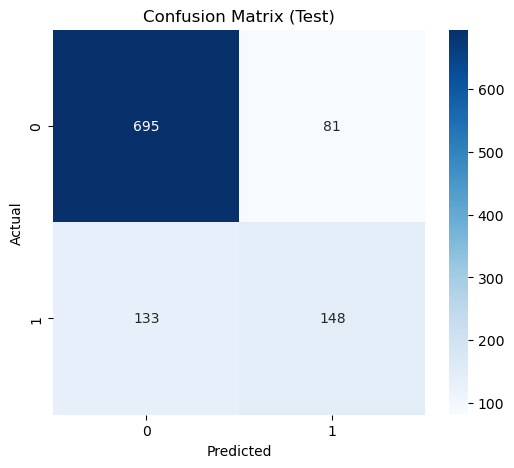

In [43]:
cm=confusion_matrix(y_test,y_pred_test_01)
cm
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

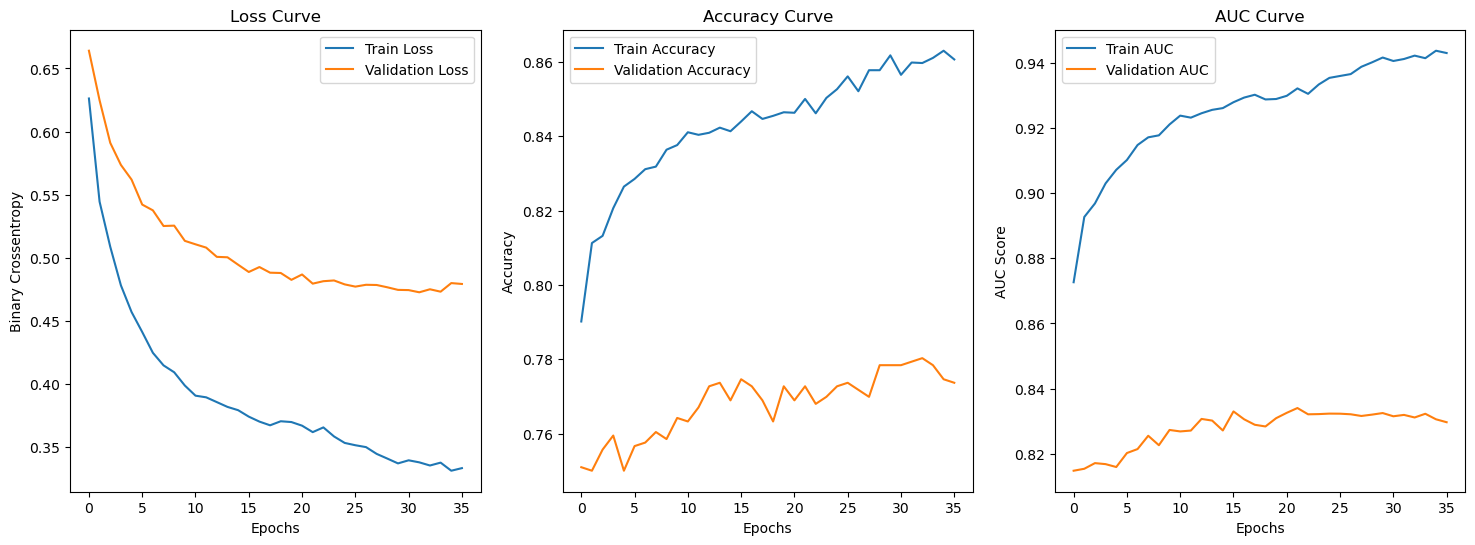

In [44]:
plot_history(history_test_01)


In [45]:
# --- ROC Curve ---

# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test_01)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')

# # --- Precision-Recall Curve ---

# precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_test_01)

# plt.subplot(1, 2, 2)
# plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.legend(loc='lower left')

# plt.tight_layout()
# plt.show()

#### Experiment 02

In [47]:
from sklearn.utils.class_weight import compute_class_weight
y_train_flat = y.squeeze()        # turns (n,1) DataFrame into (n,) Series
y_train_flat = np.ravel(y_train_flat)  # ensures it's a 1D numpy array
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flat),
    y=y_train_flat
)
class_weights = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.6806146115191342), 1: np.float64(1.8841626538255751)}


In [79]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(input_dim,)))
    # tune number of layers 1-3
    for i in range(hp.Int('num_layers', 1, 3)):
        units = hp.Int(f'units_{i}', min_value=16, max_value=256, step=16)
        model.add(keras.layers.Dense(units, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
        # optional dropout
        if hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1) > 0:
            model.add(keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # optimizer + learning rate
    opt_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    if opt_choice == 'adam':
        lr = hp.Float('adam_lr', 1e-4, 1e-2, sampling='log')
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    elif opt_choice == 'rmsprop':
        lr = hp.Float('rmsprop_lr', 1e-4, 1e-2, sampling='log')
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)
    else:
        lr = hp.Float('sgd_lr', 1e-4, 1e-2, sampling='log')
        optimizer = keras.optimizers.SGD(learning_rate=lr)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.AUC(name='auc', from_logits=False), 'accuracy'])
    return model

tuner_test_02 = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=25,
    executions_per_trial=1,
    directory='model_his_9',
    project_name='telco_churn_ann_Test_3'
)

# starts the automated process of building, training, and evaluating the 25 different model configurations defined by the RandomSearch method.
tuner_test_02.search(X_train, y_train,
             epochs=100,
             validation_data=(X_val,y_val),
             class_weight=class_weights,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)],
             batch_size=512)

Trial 25 Complete [00h 00m 03s]
val_auc: 0.8267857432365417

Best val_auc So Far: 0.8267857432365417
Total elapsed time: 00h 02m 51s


In [81]:
# 10. Get best model and evaluate on test
best_hps_test_01 = tuner_test_02.get_best_hyperparameters(num_trials=1)[0]
print(best_hps_test_01.values)
# {'num_layers': 1, 'units_0': 128, 'dropout_0': 0.30000000000000004, 'optimizer': 'adam', 'adam_lr': 0.001565283522619813, 'sgd_lr': 0.00010549791203507149, 'rmsprop_lr': 0.0001017828863875319, 'units_1': 64, 'dropout_1': 0.4, 'units_2': 80, 'dropout_2': 0.2}



{'num_layers': 2, 'units_0': 80, 'dropout_0': 0.2, 'optimizer': 'rmsprop', 'adam_lr': 0.001193677363426901, 'units_1': 160, 'dropout_1': 0.2, 'units_2': 256, 'dropout_2': 0.0, 'sgd_lr': 0.0056401558413015345, 'rmsprop_lr': 0.001786944675901127}


In [92]:
# 1. Get the best hyperparameters which gives highest val_auc
best_hps_test_02 = tuner_test_02.get_best_hyperparameters(1)[0]

# 2. Build the model using these hyperparameters
best_tuned_model_test_02 = build_model(best_hps_test_02)

# 3. Retrain the model so we get history
history_tuned_test_02 = best_tuned_model_test_02.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val,y_val),
    class_weight=class_weights,
    batch_size=2048,
    callbacks=[keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=4, restore_best_weights=True
    )],
    verbose=2
)


Epoch 1/100


c:\Users\chanu\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


4/4 - 1s - 234ms/step - accuracy: 0.5581 - auc: 0.6422 - loss: 2.0700 - val_accuracy: 0.6222 - val_auc: 0.7946 - val_loss: 1.8879
Epoch 2/100
4/4 - 0s - 23ms/step - accuracy: 0.7079 - auc: 0.8396 - loss: 1.7166 - val_accuracy: 0.6667 - val_auc: 0.8067 - val_loss: 1.7213
Epoch 3/100
4/4 - 0s - 22ms/step - accuracy: 0.7408 - auc: 0.8579 - loss: 1.5409 - val_accuracy: 0.6733 - val_auc: 0.8109 - val_loss: 1.5903
Epoch 4/100
4/4 - 0s - 21ms/step - accuracy: 0.7528 - auc: 0.8664 - loss: 1.4060 - val_accuracy: 0.6780 - val_auc: 0.8126 - val_loss: 1.4798
Epoch 5/100
4/4 - 0s - 21ms/step - accuracy: 0.7569 - auc: 0.8720 - loss: 1.2928 - val_accuracy: 0.6790 - val_auc: 0.8141 - val_loss: 1.3826
Epoch 6/100
4/4 - 0s - 21ms/step - accuracy: 0.7623 - auc: 0.8764 - loss: 1.1956 - val_accuracy: 0.6809 - val_auc: 0.8143 - val_loss: 1.2948
Epoch 7/100
4/4 - 0s - 20ms/step - accuracy: 0.7645 - auc: 0.8805 - loss: 1.1084 - val_accuracy: 0.6799 - val_auc: 0.8156 - val_loss: 1.2219
Epoch 8/100
4/4 - 0s - 2

In [93]:

 # Evaluate
y_pred_tuned_proba_test_02 = best_tuned_model_test_02.predict(X_test).ravel()
y_pred_tuned_test_02 = (y_pred_tuned_proba_test_02 >= 0.5).astype(int)

print("Test AUC:", roc_auc_score(y_test, y_pred_tuned_proba_test_02))
print("Test Accuracy:", accuracy_score(y_test, y_pred_tuned_test_02))
print(classification_report(y_test, y_pred_tuned_test_02))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test AUC: 0.8349368969439043
Test Accuracy: 0.7360454115421002
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       776
           1       0.50      0.80      0.62       281

    accuracy                           0.74      1057
   macro avg       0.71      0.76      0.71      1057
weighted avg       0.80      0.74      0.75      1057



In [94]:
print("\n=== Final Training vs Validation Performance ===")

# Get the metrics from the last epoch (or best epoch if early stopping restored weights)
train_loss = history_tuned_test_02.history['loss'][-1]
train_accuracy = history_tuned_test_02.history['accuracy'][-1]
train_auc = history_tuned_test_02.history['auc'][-1]

val_loss = history_tuned_test_02.history['val_loss'][-1]
val_accuracy = history_tuned_test_02.history['val_accuracy'][-1]
val_auc = history_tuned_test_02.history['val_auc'][-1]

print(f"Training   - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, AUC: {train_auc:.4f}")
print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, AUC: {val_auc:.4f}")
print(f"Test Accuracy       -        Accuracy: {accuracy_score(y_test, y_pred_tuned_test_02):.4f}, AUC: {roc_auc_score(y_test,y_pred_tuned_proba_test_02):.4f}")

print("Test precision:", precision_score(y_test, y_pred_tuned_test_02))
print("Test recall:", recall_score(y_test, y_pred_tuned_test_02))
print("Test f1:", f1_score(y_test, y_pred_tuned_test_02))


=== Final Training vs Validation Performance ===
Training   - Loss: 0.4582, Accuracy: 0.7938, AUC: 0.9064
Validation - Loss: 0.6190, Accuracy: 0.7178, AUC: 0.8236
Test Accuracy       -        Accuracy: 0.7360, AUC: 0.8349
Test precision: 0.5022321428571429
Test recall: 0.800711743772242
Test f1: 0.6172839506172839


In [95]:
print(f"Minimum Validation Loss: {min(history_tuned_test_02.history['val_loss']):.4f}")

Minimum Validation Loss: 0.6116


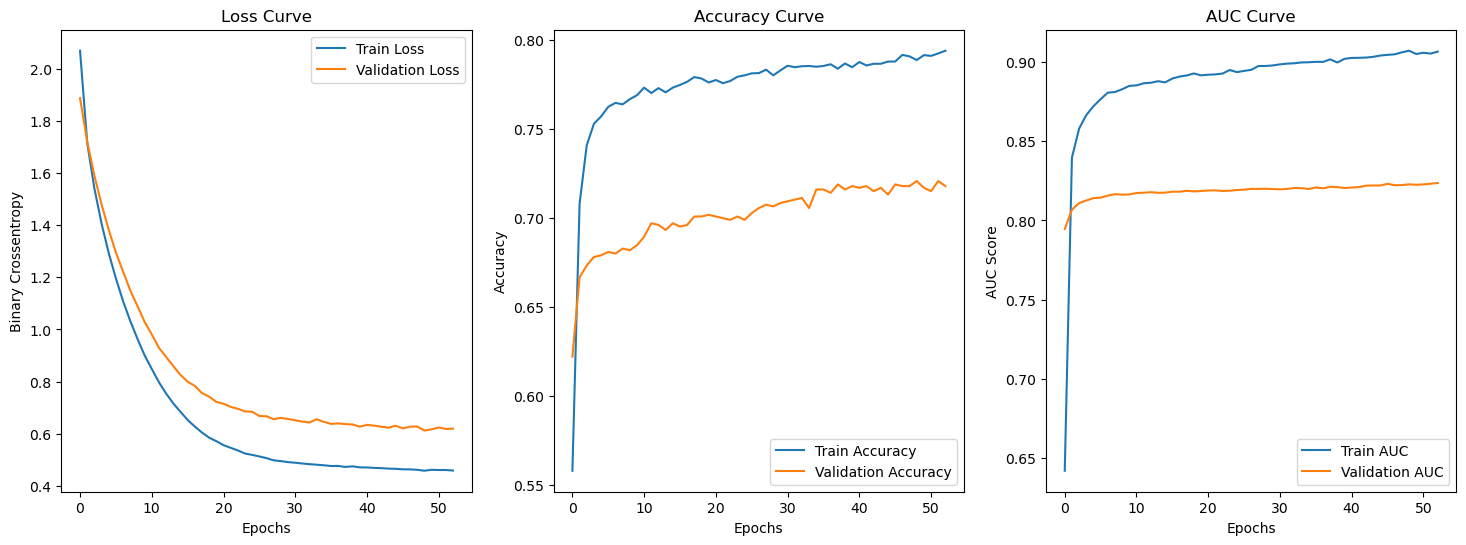

In [96]:
plot_history(history_tuned_test_02)


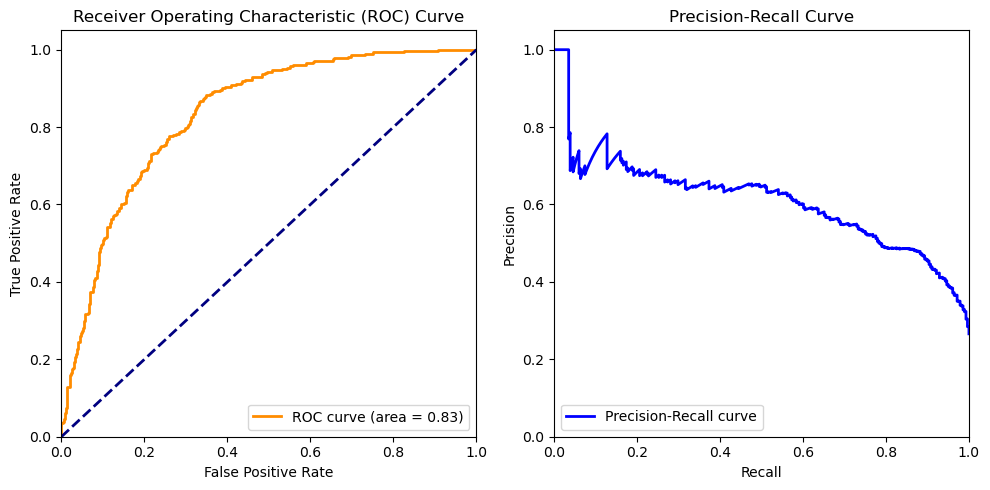

In [55]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# --- ROC Curve ---

fpr, tpr, thresholds = roc_curve(y_test, y_pred_tuned_proba_test_02)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# --- Precision-Recall Curve ---

precision, recall, _ = precision_recall_curve(y_test, y_pred_tuned_proba_test_02)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

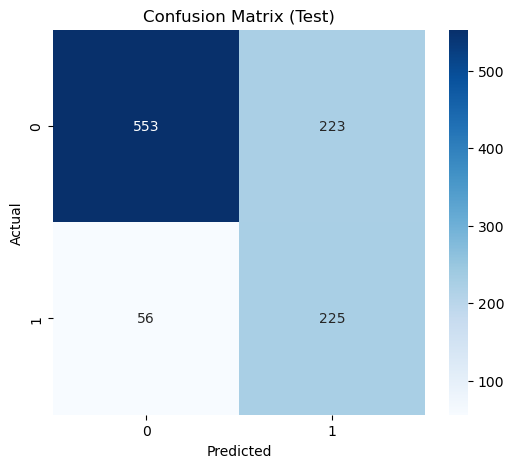

In [97]:
# best_model.save("telco_ann_best_model.h5")
cm=confusion_matrix(y_test,y_pred_tuned_test_02)
cm
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [98]:
cm

array([[553, 223],
       [ 56, 225]])

In [ ]:
# os.makedirs("models", exist_ok=True)
#
# best_tuned_model_test_02.save("models/final_ann_model.keras")


## Decision Tree Traininig

#### Test 01

In [ ]:
dt_model = DecisionTreeClassifier(
    criterion="entropy",         # Use 'entropy' for information gain
    max_depth=6,             # Prevent overfitting
    min_samples_split=40,     # Minimum samples required for a split
    min_samples_leaf=20,      # Minimum samples per leaf
  # Handle class imbalance
    random_state=42
)

# Train model
dt_model.fit(X_train, y_train)


In [ ]:
y_pred = dt_model.predict(X_test)


In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
y_pred_proba_deci_1 = dt_model.predict(X_test).ravel()
y_pred_deci_1 = (y_pred_proba_deci_1 >= 0.5).astype(int)
print("Test AUC:", roc_auc_score(y_test, y_pred_proba_deci_1))
print("Test Accuracy:", accuracy_score(y_test, y_pred_deci_1))
print(classification_report(y_test, y_pred_deci_1))

#### Test 02

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
from scipy.stats import randint, uniform

param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": randint(3, 40),           # shallow to deep
    "min_samples_split": randint(2, 50),   # min samples to split
    "min_samples_leaf": randint(1, 30),    # leaf size
    "max_features": [None, "sqrt", "log2"],
    "ccp_alpha": uniform(0.0, 0.02),       # small alphas for pruning
    # "class_weight": [None, "balanced"]
    "class_weight": [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 2, 1: 1}, "balanced"]

}
# param_dist = {
#     "criterion": ["gini", "entropy"],
#     "max_depth": [5, 7, 9, 11, 13, 15, 20, None],
#     "min_samples_split": [2, 5, 10, 20],
#     "min_samples_leaf": [1, 2, 4, 8, 16],
#     "max_features": [None, "sqrt", "log2"],
#     "ccp_alpha": [0, 0.0001, 0.001, 0.01, 0.1],  # Wider range
#     "class_weight": [None, "balanced", {0: 1, 1: 1.5}, {0: 1, 1: 2}]
# }

dt = DecisionTreeClassifier(random_state=42)


rs = RandomizedSearchCV(
    dt,
    param_distributions=param_dist,
    n_iter=150,                # number of parameter settings sampled
    scoring="roc_auc",        # or "f1" depending on priority
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

rs.fit(X_train, y_train)

print("Best params (random search):", rs.best_params_)
print("Best cross-val ROC AUC:", rs.best_score_)
best_dt = rs.best_estimator_


In [ ]:
# use best_dt or final_dt from above
model = best_dt  # or final_dt

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test precision:", precision_score(y_test, y_pred))
print("Test recall:", recall_score(y_test, y_pred))
print("Test f1:", f1_score(y_test, y_pred))
if y_prob is not None:
    print("Test ROC AUC:", roc_auc_score(y_test, y_prob))

print("\nClassification report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
param_dist = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}


rs = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=200,                # number of parameter settings sampled
    scoring="roc_auc",        # or "f1" depending on priority
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

rs.fit(X_train, y_train)

print("Best params (random search):", rs.best_params_)
print("Best cross-val ROC AUC:", rs.best_score_)
best_dt = rs.best_estimator_


In [ ]:
# use best_dt or final_dt from above
model = best_dt  # or final_dt

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test precision:", precision_score(y_test, y_pred))
print("Test recall:", recall_score(y_test, y_pred))
print("Test f1:", f1_score(y_test, y_pred))
if y_prob is not None:
    print("Test ROC AUC:", roc_auc_score(y_test, y_prob))

print("\nClassification report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#### Before hyperparameter tuning and after tuning result comparision

In [ ]:
import shutil

# Zip the kt_tuner_dir folder
shutil.make_archive("model_his_9", 'zip', "model_his_9")

# Download the zipped folder
from google.colab import files
files.download("model_his_9.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# https://www.kaggle.com/code/rakkesharv/complete-guide-decision-trees-ml-modelling#8%EF%B8%8F%E2%83%A3-Python-Implementation---Decision-Tree

# Task
Fix the `AttributeError` in cell `VsjFfrsiRjcf` by replacing `best_model.predict` with `model.predict`.

## Fix AttributeError in Evaluation Cell

### Subtask:
Modify cell `VsjFfrsiRjcf` to replace `best_model.predict` with `model.predict` to correctly reference the trained Keras model object and resolve the `AttributeError`.


## Summary:

### Data Analysis Key Findings
*   An `AttributeError` was identified in the evaluation cell (cell `VsjFfrsiRjcf`), indicating that the `predict` method could not be found on the `best_model` object.
*   The error was resolved by replacing the incorrect object reference `best_model.predict` with `model.predict`, which correctly points to the trained Keras model object.

### Insights or Next Steps
*   Always ensure that the correct variable name or object reference is used when calling methods, especially after training or loading machine learning models.
*   Consider implementing a validation step or unit tests for model prediction functions to catch such `AttributeError` instances early in the development process.
